# Long Short Term Memory

LSTM merupakan jenis arsitektur RNN yang dirancang untuk mengatasi keterbatasan RNN tradisional dalam menangkap ketergantungan jarak jauh dalam data sekuensial.

LSTM terdiri dari sel memori yang mempertahankan keadaan dari waktu ke waktu dan berbagai gates yang mengatur aliran informasi ke dalam dan keluar sel. Keunggulan utama dari LSTM adalah kemampuannya untuk belajar dan mengingat informasi dalam rentang waktu yang panjang, menjadikannya cocok untuk memodelkan data deret waktu.


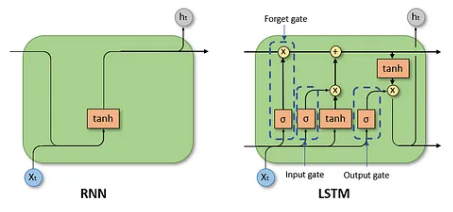

Tiga komponen utama dari sel LSTM adalah input gate, forget gate, dan output gate. Input gate menentukan seberapa banyak informasi baru yang ditambahkan ke dalam keadaan sel, forget gate mengontrol seberapa banyak informasi dari keadaan sebelumnya yang dipertahankan, dan output gate menentukan output dari sel.

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Projek Metoper 2024/Dokumen dari Ahmad Wildan JauharulFuad')

In [ ]:
df

,Month_Year,Retail,Production,Export,Import,Market
0,2017-01-01,78297,99025,15611,4084,85893
1,2017-02-01,79127,106573,18955,7351,94728
2,2017-03-01,94435,111699,21863,8583,101850
3,2017-04-01,79621,102108,18518,9836,89190
4,2017-05-01,94856,106375,20780,8711,93624
...,...,...,...,...,...,...
79,2023-08-01,86371,125648,46468,7302,88928
80,2023-09-01,80984,112783,42186,6037,79919
81,2023-10-01,79446,118309,46960,5164,80350
82,2023-11-01,82781,116266,42219,5108,84390


In [ ]:
# Reshape the DataFrame into long format
df_long = pd.melt(df, id_vars=['Month_Year'], value_vars=['Production', 'Export'],
                  var_name='unique_id', value_name='y')

# Sort by time for clarity (optional)
df_long.sort_values(by='Month_Year', inplace=True)

print("\nTransformed DataFrame:")
df_long



Transformed DataFrame:


,Month_Year,unique_id,y
0,2017-01-01,Production,99025
84,2017-01-01,Export,15611
85,2017-02-01,Export,18955
1,2017-02-01,Production,106573
2,2017-03-01,Production,111699
...,...,...,...
81,2023-10-01,Production,118309
166,2023-11-01,Export,42219
82,2023-11-01,Production,116266
83,2023-12-01,Production,97911


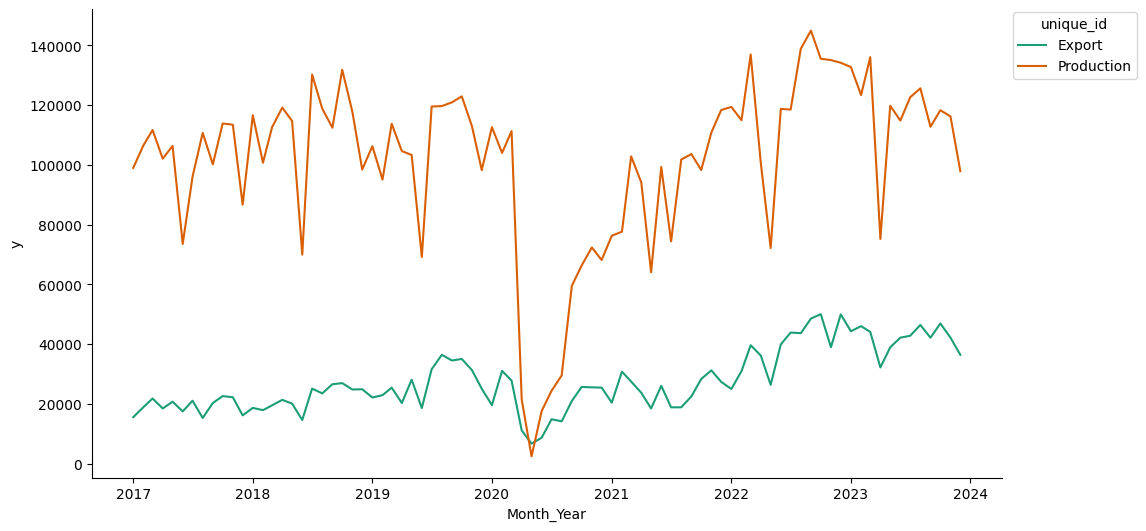

In [ ]:
# @title Month_Year vs y

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Month_Year']
  ys = series['y']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_long.sort_values('Month_Year', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('unique_id')):
  _plot_series(series, series_name, i)
fig.legend(title='unique_id', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Month_Year')
_ = plt.ylabel('y')

In [ ]:
df_long.reset_index(drop=True, inplace=True)
df_long

,Month_Year,unique_id,y
0,2017-01-01,Retail,78297
1,2017-01-01,Export,15611
2,2017-01-01,Production,99025
3,2017-01-01,Import,4084
4,2017-02-01,Retail,79127
...,...,...,...
331,2023-11-01,Retail,82781
332,2023-12-01,Production,97911
333,2023-12-01,Retail,89586
334,2023-12-01,Export,36449


In [ ]:
df_long = df_long[df_long['unique_id'] == 'Export']
df_long.reset_index(inplace=True, drop=True)

In [ ]:
df_long

,Month_Year,unique_id,y
0,2017-01-01,Export,15611
1,2017-02-01,Export,18955
2,2017-03-01,Export,21863
3,2017-04-01,Export,18518
4,2017-05-01,Export,20780
...,...,...,...
79,2023-08-01,Export,46468
80,2023-09-01,Export,42186
81,2023-10-01,Export,46960
82,2023-11-01,Export,42219


In [ ]:
df = df_long[['y']]

In [ ]:
import numpy as np
import tensorflow as tf

In [ ]:
df.shape

(84, 1)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df).reshape(-1,1))

In [ ]:
split_point = int(np.floor(80/100*df1.shape[0]))
split_point

67

In [ ]:
training_size = int(len(df1)*0.65)
test_size = len(df1) - training_size
train_data, test_data = df1[0:training_size,:],df1[training_size:len(df1),:1]

In [ ]:
# Preprocess data
def preprocess_data(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps-1):
        X.append(data[i:i+time_steps,0])
        y.append(data[i+time_steps,0])
    return np.array(X), np.array(y)

In [ ]:
time_steps = 2
X_train, y_train = preprocess_data(train_data, time_steps)
X_test, y_test = preprocess_data(test_data, time_steps)

In [ ]:
#reshape input to b samples, time_steps, features
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [ ]:
# Build LSTM model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, input_shape=(time_steps, 1), return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1, validation_split = 0.2)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print("Test Loss:", loss)

Epoch 1/100
1/1 [==============================] - 7s 7s/step - loss: 0.1549 - val_loss: 0.1421
Epoch 2/100
1/1 [==============================] - 0s 46ms/step - loss: 0.1501 - val_loss: 0.1376
Epoch 3/100
1/1 [==============================] - 0s 47ms/step - loss: 0.1455 - val_loss: 0.1330
Epoch 4/100
1/1 [==============================] - 0s 48ms/step - loss: 0.1408 - val_loss: 0.1284
Epoch 5/100
1/1 [==============================] - 0s 50ms/step - loss: 0.1361 - val_loss: 0.1237
Epoch 6/100
1/1 [==============================] - 0s 47ms/step - loss: 0.1313 - val_loss: 0.1188
Epoch 7/100
1/1 [==============================] - 0s 80ms/step - loss: 0.1263 - val_loss: 0.1138
Epoch 8/100
1/1 [==============================] - 0s 50ms/step - loss: 0.1212 - val_loss: 0.1086
Epoch 9/100
1/1 [==============================] - 0s 51ms/step - loss: 0.1159 - val_loss: 0.1031
Epoch 10/100
1/1 [==============================] - 0s 47ms/step - loss: 0.1103 - val_loss: 0.0975
Epoch 11/100
1/1 [===

In [ ]:
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error as MAPE

In [ ]:
# Lets do prediction and check performance matrix
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

1/1 [==============================] - 0s 25ms/step


In [ ]:
print(mean_squared_error(y_test,test_predict))
print(mean_squared_error(y_train,train_predict))

0.08032139046962637
0.01629000459284152


In [ ]:
#Transform back to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [ ]:
print(mean_squared_error(y_test,test_predict))
print(mean_squared_error(y_train,train_predict))

811129575.2858994
502992923.93681


In [ ]:
import matplotlib.pyplot as plt

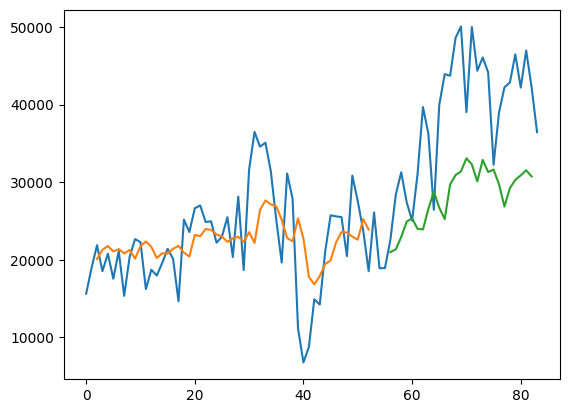

In [ ]:
####Plotting
# shift train prediction for plotting
look_back = time_steps
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back,:] = train_predict

testPredictPlot = np.empty_like(df1)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1,:] = test_predict

plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
x_input = df1[-time_steps:].reshape(1,-1)
x_input.shape

(1, 2)

In [ ]:
temp_input = list(x_input)
temp_input=temp_input[0].tolist()

In [ ]:
st_output = []
n_steps = time_steps
i=0
while(i<12):
    if(len(temp_input)>time_steps):
        x_input = np.array(temp_input[1:])
        print("{} day input{}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1,n_steps,1))

        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]

        st_output.extend(yhat.tolist())
        i= i+1
    else:
        x_input = x_input.reshape((1,n_steps,1))
        yhat = model.predict(x_input,verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        st_output.extend(yhat.tolist())
        i=i+1

print(st_output)

[0.5271663]
3
1 day input[0.68569911 0.52716631]
1 day output [[0.46987653]]
2 day input[0.52716631 0.46987653]
2 day output [[0.41718498]]
3 day input[0.46987653 0.41718498]
3 day output [[0.39525554]]
4 day input[0.41718498 0.39525554]
4 day output [[0.37799042]]
5 day input[0.39525554 0.37799042]
5 day output [[0.37004915]]
6 day input[0.37799042 0.37004915]
6 day output [[0.36438468]]
7 day input[0.37004915 0.36438468]
7 day output [[0.3615874]]
8 day input[0.36438468 0.36158741]
8 day output [[0.3597179]]
9 day input[0.36158741 0.35971791]
9 day output [[0.35874736]]
10 day input[0.35971791 0.35874736]
10 day output [[0.3581265]]
11 day input[0.35874736 0.35812649]
11 day output [[0.35779282]]
[[0.5271663069725037], [0.4698765277862549], [0.417184978723526], [0.39525553584098816], [0.3779904246330261], [0.3700491487979889], [0.3643846809864044], [0.36158740520477295], [0.3597179055213928], [0.35874736309051514], [0.3581264913082123], [0.35779282450675964]]


In [ ]:
day_new = np.arange(0,84)
day_pred = np.arange(84,96)

In [ ]:
df3= df1.tolist()
df3.extend(st_output)

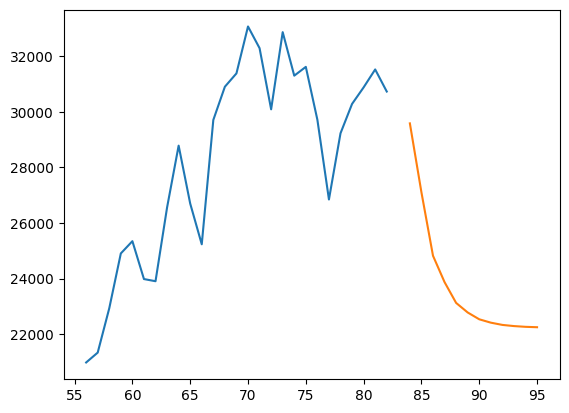

In [ ]:
plt.plot(testPredictPlot)
plt.plot(day_pred,scaler.inverse_transform(st_output))

In [ ]:
scaler.inverse_transform(df1).shape

(84, 1)

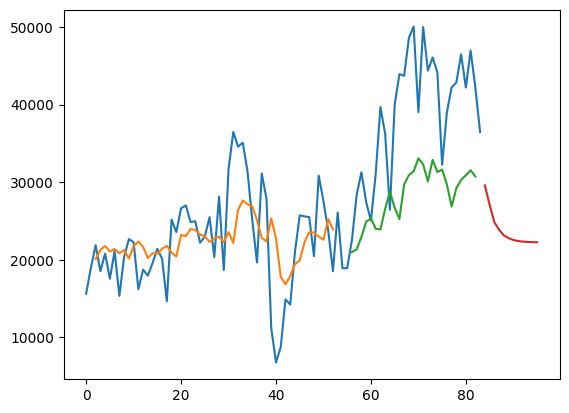

In [ ]:
plt.plot(day_new,scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.plot(day_pred,scaler.inverse_transform(st_output))

In [ ]:
future = scaler.inverse_transform(st_output).tolist()

future = {"Close" : future}
df_future = pd.DataFrame(future)
df_future

,Close
0,[29582.62708759308]
1,[27101.29217147827]
2,[24819.115798473358]
3,[23869.30776834488]
4,[23121.521271705627]
5,[22777.568732738495]
6,[22532.22930288315]
7,[22411.073694229126]
8,[22330.101923942566]
9,[22288.06579017639]
